In [2]:
from functions import *

ModuleNotFoundError: No module named 'functions'

# Saving Files

In [2]:
sub = pd.read_csv('_Submissions.csv')

In [3]:
df_list = list(sub[sub['SIC']==2834]['CIK'].unique())

In [4]:
new_list = cik_to_file(df_list)

In [5]:
df_merged = convertor_multiple(new_list)

Key 'us-gaap' missing in file companyfacts/CIK0001712641.json. Skipping this file.
Key 'us-gaap' missing in file companyfacts/CIK0001114448.json. Skipping this file.
Key 'us-gaap' missing in file companyfacts/CIK0001840748.json. Skipping this file.
Key 'us-gaap' missing in file companyfacts/CIK0001259942.json. Skipping this file.
Key 'us-gaap' missing in file companyfacts/CIK0001131399.json. Skipping this file.
Key 'us-gaap' missing in file companyfacts/CIK0001719714.json. Skipping this file.
Key 'us-gaap' missing in file companyfacts/CIK0001782999.json. Skipping this file.
Key 'us-gaap' missing in file companyfacts/CIK0001620737.json. Skipping this file.
Key 'us-gaap' missing in file companyfacts/CIK0001479615.json. Skipping this file.
Key 'us-gaap' missing in file companyfacts/CIK0001512717.json. Skipping this file.
Key 'us-gaap' missing in file companyfacts/CIK0001553846.json. Skipping this file.
Key 'us-gaap' missing in file companyfacts/CIK0001434265.json. Skipping this file.
Key 

In [6]:
df_info(df_merged)

(0.99, (39825, 5746))

In [33]:
len(df_merged['CIK'].unique())

911

In [7]:
df_merged.


('all_2834.csv',mode='w',index=False)

In [43]:
chosen_years(df_merged[list(df_merged.columns[:7])+['NetIncomeLoss']].sort_values(by=['CIK','Frame'])).to_csv('all_annual_2834_target.csv',mode='w',index=False)

In [13]:
df_merged[(df_merged['CIK'] == 812306) & (df_merged['Frame'] == 'CY2015')]['NetIncomeLoss']

24301   NaN
Name: NetIncomeLoss, dtype: float64

# Model

In [43]:
df = pd.read_csv('all_annual_2834.csv')

In [14]:
pd.DataFrame(feature_importances).to_csv('feat_impo.csv',mode='w',index=True)

In [27]:
def everything(df_list,lvl1,lvl2,shift,chunk,threshold,target_shift,testsize):
    new_list = cik_to_file(df_list)
    df_merged = convertor_multiple(new_list)
    df_merged = chosen_years(df_merged)
    na_maxed = na_max(df_merged,threshold)
    na_maxed = na_maxed.dropna(subset=['NetIncomeLoss'])
    na_maxed = na_maxed.drop(['End',	'EntityName',	'FP',	'Filed',	'Form'],axis=1)
    df_1 = percent_diff(na_maxed)
    merged = process_in_chunks(df_1,lvl1,lvl2,shift,chunk)
    df_targeted=target_dropna(merged,lvl1,lvl2,target_shift)
    df_shuffled = df_targeted.sample(frac=1, random_state=42)
    train_set, test_set = train_test_split(df_shuffled, test_size=testsize, random_state=42)
    df = train_set
    df2 = test_set
    rf_model, train_accuracy, train_roc_auc = train_random_forest(df, 'target')
    feature_importances = rf_model.feature_importances_
    # Create a pandas series with the feature importances
    importances = pd.Series(feature_importances, index=df.columns[:-1])  # assuming last column is 'target'
    # Sort the feature importances in descending order
    sorted_importances = importances.sort_values(ascending=False)

    # Print the feature importances
    print("Feature Importances:\n", sorted_importances)
    save_model(rf_model, 'random_forest_classifier.joblib')
    rf_model_loaded = load_model('random_forest_classifier.joblib')
    unseen_accuracy, unseen_roc_auc = evaluate_model(rf_model_loaded, df2, 'target')
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Training ROC AUC: {train_roc_auc}")
    print(f"Unseen Data Accuracy: {unseen_accuracy}")
    print(f"Unseen Data ROC AUC: {unseen_roc_auc}")
    print(df_info(df))

    return train_accuracy, train_roc_auc, unseen_accuracy, unseen_roc_auc, sorted_importances

In [63]:
df  = df   #List of CIKs of companies to test.
lvl1      = 'CIK'     #Level 1 index to pivot.
lvl2      = 'Frame'   #Level 2 index to pivot. 
shifts    = 1       #Number of Shifts/Lags
chunks    = 10        #Chunks to Divide
threshold = 0.8       #Threshold of Missing Values in a column
target    = f'NetIncomeLoss_{shifts}' #Target column make into target.
test_size = 0.3       #Test split size for first round.

train_accuracy, train_roc_auc, unseen_accuracy, unseen_roc_auc, feature_importances = everything(df, lvl1, lvl2, shifts, chunks, threshold, target, test_size)

Feature Importances:
 NetIncomeLoss_1                                                                                        0.114359
OperatingIncomeLoss_1                                                                                  0.031036
ComprehensiveIncomeNetOfTax_1                                                                          0.024818
NetIncomeLoss                                                                                          0.018927
EarningsPerShareBasicAndDiluted_1                                                                      0.017180
                                                                                                         ...   
CurrentStateAndLocalTaxExpenseBenefit                                                                  0.001356
ShareBasedCompensationArrangementByShareBasedPaymentAwardFairValueAssumptionsExpectedDividendRate_1    0.000142
NumberOfOperatingSegments_1                                                       

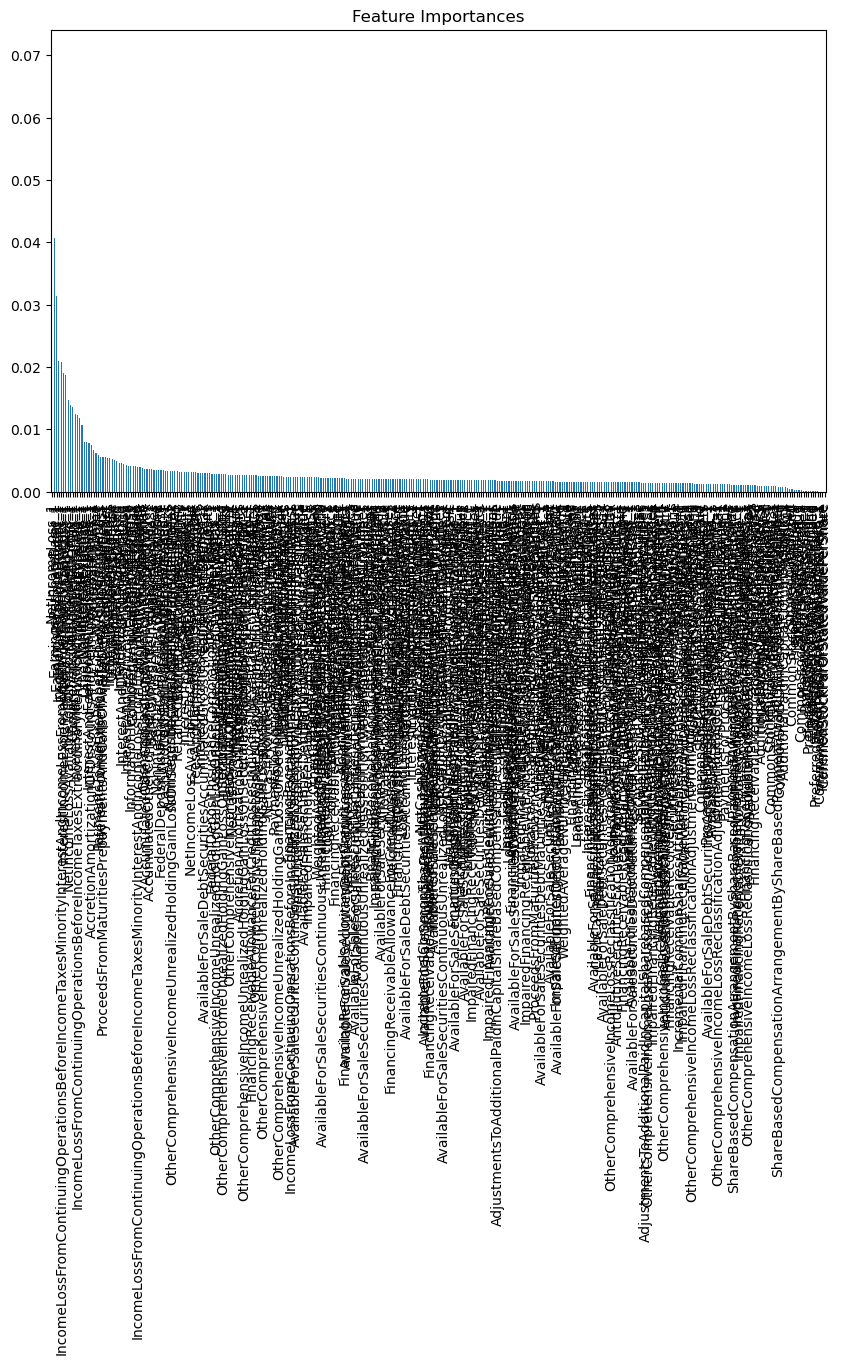

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.show()


In [28]:
sub = pd.read_csv('_Submissions.csv')

In [29]:
sic = pd.read_csv('_sic_counts.csv')

In [30]:
sic

,SIC,Count,Description
0,NaN,2008,NaN
1,2834.0,1087,Pharmaceutical Preparations
2,6770.0,1045,Blank Checks
3,7372.0,653,Services-Prepackaged Software
4,6798.0,502,Real Estate Investment Trusts
...,...,...,...
430,7384.0,1,Services-Photofinishing Laboratories
431,3260.0,1,Pottery & Related Products
432,2092.0,1,Prepared Fresh or Frozen Fish & Seafoods
433,2253.0,1,Knit Outerwear Mills


In [31]:
df_list   = list(sub[sub['SIC']==6770]['CIK'].unique())   #List of CIKs of companies to test.
lvl1      = 'CIK'     #Level 1 index to pivot.
lvl2      = 'Frame'   #Level 2 index to pivot. 
shifts    = 1       #Number of Shifts/Lags
chunks    = 10        #Chunks to Divide
threshold = 0.8       #Threshold of Missing Values in a column
target    = f'NetIncomeLoss_{shifts}' #Target column make into target.
test_size = 0.3       #Test split size for first round.

train_accuracy, train_roc_auc, unseen_accuracy, unseen_roc_auc, feature_importances = everything(df_list, lvl1, lvl2, shifts, chunks, threshold, target, test_size)

Feature Importances:
 NetIncomeLoss_1                                0.103615
GeneralAndAdministrativeExpense_1              0.056380
OperatingExpenses_1                            0.052932
OperatingIncomeLoss                            0.040857
GeneralAndAdministrativeExpense                0.040107
                                                 ...   
PaymentsOfStockIssuanceCosts                   0.000752
PaymentsOfStockIssuanceCosts_1                 0.000285
FairValueAdjustmentOfWarrants                  0.000205
ProceedsFromIssuanceInitialPublicOffering      0.000200
ProceedsFromIssuanceInitialPublicOffering_1    0.000000
Length: 66, dtype: float64
Training Accuracy: 0.7578947368421053
Training ROC AUC: 0.7661538461538462
Unseen Data Accuracy: 0.6444444444444445
Unseen Data ROC AUC: 0.7229080932784636
(0.0, (315, 67))


In [32]:
df_list   = list(sub[sub['SIC']==7372]['CIK'].unique())   #List of CIKs of companies to test.
lvl1      = 'CIK'     #Level 1 index to pivot.
lvl2      = 'Frame'   #Level 2 index to pivot. 
shifts    = 1       #Number of Shifts/Lags
chunks    = 10        #Chunks to Divide
threshold = 0.8       #Threshold of Missing Values in a column
target    = f'NetIncomeLoss_{shifts}' #Target column make into target.
test_size = 0.3       #Test split size for first round.

train_accuracy, train_roc_auc, unseen_accuracy, unseen_roc_auc, feature_importances = everything(df_list, lvl1, lvl2, shifts, chunks, threshold, target, test_size)

Feature Importances:
 NetIncomeLoss_1                                                                                        0.058559
ComprehensiveIncomeNetOfTax_1                                                                          0.020350
EarningsPerShareBasic_1                                                                                0.018592
CashAndCashEquivalentsPeriodIncreaseDecrease_1                                                         0.014054
OperatingIncomeLoss_1                                                                                  0.013897
                                                                                                         ...   
NumberOfOperatingSegments_1                                                                            0.000196
GoodwillImpairmentLoss                                                                                 0.000153
ShareBasedCompensationArrangementByShareBasedPaymentAwardFairValueAssumptionsExpec

In [33]:
df_list   = list(sub[sub['SIC']==6798]['CIK'].unique())   #List of CIKs of companies to test.
lvl1      = 'CIK'     #Level 1 index to pivot.
lvl2      = 'Frame'   #Level 2 index to pivot. 
shifts    = 1       #Number of Shifts/Lags
chunks    = 10        #Chunks to Divide
threshold = 0.8       #Threshold of Missing Values in a column
target    = f'NetIncomeLoss_{shifts}' #Target column make into target.
test_size = 0.3       #Test split size for first round.

train_accuracy, train_roc_auc, unseen_accuracy, unseen_roc_auc, feature_importances = everything(df_list, lvl1, lvl2, shifts, chunks, threshold, target, test_size)

Feature Importances:
 NetIncomeLoss_1                                                          0.071096
ProfitLoss_1                                                             0.042477
EarningsPerShareDiluted_1                                                0.027631
EarningsPerShareBasic_1                                                  0.021856
ComprehensiveIncomeNetOfTax_1                                            0.021567
                                                                           ...   
EffectiveIncomeTaxRateReconciliationAtFederalStatutoryIncomeTaxRate_1    0.000936
AmortizationOfDebtDiscountPremium                                        0.000933
NumberOfReportableSegments_1                                             0.000619
EffectiveIncomeTaxRateReconciliationAtFederalStatutoryIncomeTaxRate      0.000444
NumberOfReportableSegments                                               0.000331
Length: 250, dtype: float64
Training Accuracy: 0.6836027713625866
Training R

In [34]:
df_list   = list(sub[sub['SIC']==1311]['CIK'].unique())   #List of CIKs of companies to test.
lvl1      = 'CIK'     #Level 1 index to pivot.
lvl2      = 'Frame'   #Level 2 index to pivot. 
shifts    = 1       #Number of Shifts/Lags
chunks    = 10        #Chunks to Divide
threshold = 0.8       #Threshold of Missing Values in a column
target    = f'NetIncomeLoss_{shifts}' #Target column make into target.
test_size = 0.3       #Test split size for first round.

train_accuracy, train_roc_auc, unseen_accuracy, unseen_roc_auc, feature_importances = everything(df_list, lvl1, lvl2, shifts, chunks, threshold, target, test_size)

Feature Importances:
 NetIncomeLoss_1                                                                    0.101120
EarningsPerShareDiluted_1                                                          0.049801
IncomeTaxReconciliationIncomeTaxExpenseBenefitAtFederalStatutoryIncomeTaxRate_1    0.026234
EarningsPerShareBasic_1                                                            0.025502
OperatingIncomeLoss_1                                                              0.024414
                                                                                     ...   
InterestCostsCapitalized_1                                                         0.000760
UnrealizedGainLossOnDerivatives                                                    0.000722
AccretionOfDiscount_1                                                              0.000654
IncomeTaxesPaid_1                                                                  0.000605
InterestCostsCapitalized                                  

In [35]:
df_list   = list(sub[sub['SIC']==6022]['CIK'].unique())   #List of CIKs of companies to test.
lvl1      = 'CIK'     #Level 1 index to pivot.
lvl2      = 'Frame'   #Level 2 index to pivot. 
shifts    = 1       #Number of Shifts/Lags
chunks    = 10        #Chunks to Divide
threshold = 0.8       #Threshold of Missing Values in a column
target    = f'NetIncomeLoss_{shifts}' #Target column make into target.
test_size = 0.3       #Test split size for first round.

train_accuracy, train_roc_auc, unseen_accuracy, unseen_roc_auc, feature_importances = everything(df_list, lvl1, lvl2, shifts, chunks, threshold, target, test_size)

Feature Importances:
 EarningsPerShareBasic_1                              0.051213
EarningsPerShareDiluted_1                            0.045908
NetIncomeLoss_1                                      0.035528
InterestPaidNet                                      0.017976
NetIncomeLossAvailableToCommonStockholdersBasic_1    0.012441
                                                       ...   
GoodwillAcquiredDuringPeriod                         0.000152
GoodwillImpairmentLoss_1                             0.000084
NumberOfReportableSegments                           0.000000
GoodwillImpairmentLoss                               0.000000
NumberOfReportableSegments_1                         0.000000
Length: 384, dtype: float64
Training Accuracy: 0.7727272727272727
Training ROC AUC: 0.861111111111111
Unseen Data Accuracy: 0.7720848056537103
Unseen Data ROC AUC: 0.8766389874338882
(0.0, (1320, 385))


In [36]:
df_list   = list(sub[sub['SIC']==7389]['CIK'].unique())   #List of CIKs of companies to test.
lvl1      = 'CIK'     #Level 1 index to pivot.
lvl2      = 'Frame'   #Level 2 index to pivot. 
shifts    = 1       #Number of Shifts/Lags
chunks    = 10        #Chunks to Divide
threshold = 0.8       #Threshold of Missing Values in a column
target    = f'NetIncomeLoss_{shifts}' #Target column make into target.
test_size = 0.3       #Test split size for first round.

train_accuracy, train_roc_auc, unseen_accuracy, unseen_roc_auc, feature_importances = everything(df_list, lvl1, lvl2, shifts, chunks, threshold, target, test_size)

Feature Importances:
 NetIncomeLoss_1                                                                                        0.054594
EarningsPerShareBasic_1                                                                                0.032570
OperatingIncomeLoss_1                                                                                  0.017933
EarningsPerShareDiluted_1                                                                              0.016831
ComprehensiveIncomeNetOfTax_1                                                                          0.015337
                                                                                                         ...   
ShareBasedCompensationArrangementByShareBasedPaymentAwardFairValueAssumptionsExpectedDividendRate_1    0.000501
NumberOfReportableSegments                                                                             0.000450
GoodwillImpairmentLoss                                                            

In [15]:
df_list   = list(sub[sub['SIC']==6022]['CIK'].unique())

In [17]:
new_list = cik_to_file(df_list)

In [18]:
df_merged = convertor_multiple(new_list)

In [26]:
df_info(df_merged)

(0.97, (18431, 5703))

In [22]:
na_maxed = na_max(df_merged,0.8)

In [25]:
na_maxed.to_csv('df_merged_6022.csv',mode='w',index=False)

In [ ]:
na_maxed = na_max(df_merged,0.8)
na_maxed = na_maxed.dropna(subset=['NetIncomeLoss'])
na_maxed = na_maxed.drop(['End',	'EntityName',	'FP',	'Filed',	'Form'],axis=1)
df_1 = percent_diff(na_maxed)

In [38]:
sic.iloc[1:]

,SIC,Count,Description
1,2834.0,1087,Pharmaceutical Preparations
2,6770.0,1045,Blank Checks
3,7372.0,653,Services-Prepackaged Software
4,6798.0,502,Real Estate Investment Trusts
5,1311.0,441,Crude Petroleum & Natural Gas
...,...,...,...
430,7384.0,1,Services-Photofinishing Laboratories
431,3260.0,1,Pottery & Related Products
432,2092.0,1,Prepared Fresh or Frozen Fish & Seafoods
433,2253.0,1,Knit Outerwear Mills


In [58]:
numbers = [
    2834, 6770, 7372, 6798, 1311, 6022, 7389, 2836, 
    3841, 3674, 7374, 1000, 6021, 6500, 6035, 1040, 
    6221, 7370, 4911, 6199, 8742, 5812, 8200, 7371, 
    7373, 6331, 4813, 2860
]


In [41]:
sub = pd.read_csv('_Submissions.csv')

In [42]:
list(sub[sub['SIC']==2834]['CIK'].unique())

[1438569,
 1069308,
 1799788,
 1845337,
 1689813,
 1460602,
 1712641,
 1177648,
 1723059,
 806592,
 1679082,
 1373707,
 1598646,
 1114448,
 1454189,
 1435530,
 1755237,
 1731176,
 1657312,
 94784,
 1796129,
 1896212,
 1375850,
 1840748,
 1580149,
 1360214,
 1404943,
 1501989,
 1351288,
 1578845,
 1597264,
 1094847,
 1205922,
 1484478,
 1100962,
 1449447,
 1593899,
 1860782,
 1610820,
 1017491,
 878088,
 1479419,
 1059784,
 1133869,
 1859007,
 1478121,
 1790340,
 1653629,
 1662524,
 1415684,
 919745,
 1420030,
 1937653,
 1782107,
 1042074,
 1745020,
 1474952,
 1005286,
 1481512,
 1636050,
 827871,
 1843762,
 822370,
 1728117,
 1708688,
 1285819,
 1742927,
 1825367,
 1828522,
 1106838,
 1326205,
 1281895,
 1537663,
 1719406,
 1036968,
 894158,
 1395937,
 1468639,
 1595097,
 875622,
 1801198,
 1347242,
 1722890,
 1492426,
 1221749,
 1574094,
 1873835,
 1175680,
 1567529,
 1733413,
 1671502,
 1060426,
 1946399,
 1521762,
 1386858,
 1822791,
 356591,
 1819615,
 1322505,
 1802665,
 1696396,


# Loop Through SIC running Function

In [2]:
lvl1      = 'CIK'     #Level 1 index to pivot.
lvl2      = 'Frame'   #Level 2 index to pivot. 
shifts    = 2       #Number of Shifts/Lags
chunks    = 10        #Chunks to Divide
threshold = 0.8       #Threshold of Missing Values in a column
target    = f'NetIncomeLoss_{shifts}' #Target column make into target.
test_size = 0.3       #Test split size for first round.
results_df = pd.DataFrame(columns=['File', 'Train Accuracy', 'Train ROC AUC', 'Unseen Accuracy', 'Unseen ROC AUC','Shape'])
for i in os.listdir('sics_merged'):
    if i.endswith('.csv'):
        df = pd.read_csv(f'sics_merged/{i}')
        df_shape, train_accuracy, train_roc_auc, unseen_accuracy, unseen_roc_auc, feature_importances = everything_v2(df, lvl1, lvl2, shifts, chunks, threshold, target, test_size)
        
        # Append results to the dataframe
        results_df = results_df.append({
            'File': i,
            'Train Accuracy': train_accuracy,
            'Train ROC AUC': train_roc_auc,
            'Unseen Accuracy': unseen_accuracy,
            'Unseen ROC AUC': unseen_roc_auc,
            'Shape': df_shape
        }, ignore_index=True)
results_df.to_csv('all_sics_result.csv',mode='w',index=False)

Feature Importances:
 NetIncomeLoss_2                                                                                        0.057558
OperatingIncomeLoss_2                                                                                  0.021314
ComprehensiveIncomeNetOfTax_2                                                                          0.019222
EarningsPerShareBasicAndDiluted_2                                                                      0.016697
ProfitLoss_2                                                                                           0.015844
                                                                                                         ...   
NumberOfOperatingSegments_2                                                                            0.000000
ShareBasedCompensationArrangementByShareBasedPaymentAwardFairValueAssumptionsExpectedDividendRate_2    0.000000
NumberOfOperatingSegments_1                                                       

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                                                                   0.061821
EarningsPerShareBasicAndDiluted_2                                                                                 0.022369
IncreaseDecreaseInAccountsPayableAndAccruedLiabilities_2                                                          0.021213
ComprehensiveIncomeNetOfTax_2                                                                                     0.017789
EarningsPerShareDiluted_2                                                                                         0.017433
                                                                                                                    ...   
NetCashProvidedByUsedInFinancingActivitiesContinuingOperations_1                                                  0.000831
NetCashProvidedByUsedInFinancingActivitiesContinuingOperations                                                    0.0

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                                                        0.075238
EarningsPerShareBasicAndDiluted_2                                                                      0.036463
OperatingIncomeLoss_2                                                                                  0.028707
ComprehensiveIncomeNetOfTax_2                                                                          0.022712
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest_2          0.018852
                                                                                                         ...   
ShareBasedCompensationArrangementByShareBasedPaymentAwardFairValueAssumptionsExpectedDividendRate_1    0.000407
ShareBasedCompensationArrangementByShareBasedPaymentAwardFairValueAssumptionsExpectedDividendRate      0.000212
NumberOfOperatingSegments                                                         

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                                                  0.065807
IncreaseDecreaseInAccountsPayableAndAccruedLiabilities_1                                         0.024137
OperatingIncomeLoss_2                                                                            0.022803
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest_2    0.021811
Depreciation                                                                                     0.021407
                                                                                                   ...   
DeferredIncomeTaxExpenseBenefit_2                                                                0.000413
GainsLossesOnExtinguishmentOfDebt                                                                0.000372
IncomeTaxesPaid                                                                                  0.000245
GainsLossesOnExtinguishm

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                                                       0.031465
EarningsPerShareBasic_2                                                                               0.025051
EarningsPerShareDiluted_2                                                                             0.023052
IncrementalCommonSharesAttributableToShareBasedPaymentArrangements                                    0.010324
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest_2         0.009861
                                                                                                        ...   
OperatingLeasePayments                                                                                0.000000
OtherComprehensiveIncomeLossForeignCurrencyTransactionAndTranslationAdjustmentNetOfTax                0.000000
GoodwillImpairmentLoss                                                                    

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                        0.052365
ComprehensiveIncomeNetOfTax_2                                          0.025175
EarningsPerShareBasic_2                                                0.025090
EarningsPerShareDiluted_2                                              0.020903
IncreaseDecreaseInPrepaidDeferredExpenseAndOtherAssets_2               0.018262
                                                                         ...   
GoodwillImpairmentLoss_1                                               0.000000
GoodwillImpairmentLoss_2                                               0.000000
AllocatedShareBasedCompensationExpense_2                               0.000000
NumberOfOperatingSegments                                              0.000000
EffectiveIncomeTaxRateReconciliationAtFederalStatutoryIncomeTaxRate    0.000000
Length: 345, dtype: float64
Training Accuracy: 0.6923076923076923
Training ROC AUC: 0.676900584795

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                                                                0.068025
OperatingIncomeLoss_2                                                                                          0.019174
OperatingExpenses_2                                                                                            0.018709
ComprehensiveIncomeNetOfTax_2                                                                                  0.017935
EarningsPerShareBasicAndDiluted_2                                                                              0.017100
                                                                                                                 ...   
ShareBasedCompensationArrangementsByShareBasedPaymentAwardOptionsGrantsInPeriodWeightedAverageExercisePrice    0.000181
IncomeTaxReconciliationStateAndLocalIncomeTaxes_1                                                              0.000105
GoodwillImpairment

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                 0.076701
OperatingIncomeLoss_2                           0.047583
GeneralAndAdministrativeExpense_1               0.037133
GeneralAndAdministrativeExpense_2               0.034558
NetCashProvidedByUsedInOperatingActivities_2    0.027727
                                                  ...   
ProceedsFromIssuanceInitialPublicOffering_1     0.000000
PaymentsOfStockIssuanceCosts                    0.000000
EffectiveIncomeTaxRateContinuingOperations_2    0.000000
ProceedsFromIssuanceInitialPublicOffering       0.000000
FairValueAdjustmentOfWarrants                   0.000000
Length: 99, dtype: float64
Training Accuracy: 0.5
Training ROC AUC: 0.5296442687747035
Unseen Data Accuracy: 0.7216494845360825
Unseen Data ROC AUC: 0.8330555555555555
(0.0, (226, 100))


/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                          0.052247
ProfitLoss_2                                                             0.032710
ComprehensiveIncomeNetOfTax_2                                            0.027866
EarningsPerShareDiluted_2                                                0.020917
NetIncomeLossAvailableToCommonStockholdersBasic_2                        0.016688
                                                                           ...   
IncomeLossFromDiscontinuedOperationsNetOfTax_2                           0.000289
NumberOfReportableSegments_1                                             0.000265
EffectiveIncomeTaxRateReconciliationAtFederalStatutoryIncomeTaxRate_1    0.000165
NumberOfReportableSegments                                               0.000126
NumberOfReportableSegments_2                                             0.000087
Length: 375, dtype: float64
Training Accuracy: 0.713091922005571
Training RO

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                                        0.072832
NetCashProvidedByUsedInFinancingActivities_2                                           0.015105
IncreaseDecreaseInInventories                                                          0.013636
EarningsPerShareBasic                                                                  0.012905
IncreaseDecreaseInAccountsReceivable_2                                                 0.012736
                                                                                         ...   
ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsGrantsInPeriodGross    0.000196
IncomeTaxReconciliationStateAndLocalIncomeTaxes                                        0.000162
EffectiveIncomeTaxRateReconciliationOtherAdjustments                                   0.000000
EffectiveIncomeTaxRateReconciliationAtFederalStatutoryIncomeTaxRate_2                  0.000000
ProvisionForDoubtf

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                0.155502
EarningsPerShareBasic_2                        0.026139
Revenues_2                                     0.024190
UnrealizedGainLossOnInvestments                0.023808
OperatingExpenses_1                            0.020512
                                                 ...   
StockRedeemedOrCalledDuringPeriodValue         0.003576
IncreaseDecreaseInPayablesToBrokerDealers_1    0.003503
StockIssuedDuringPeriodSharesNewIssues_2       0.003468
StockRedeemedOrCalledDuringPeriodValue_1       0.002963
GainLossOnSaleOfInvestments                    0.002259
Length: 90, dtype: float64
Training Accuracy: 0.71
Training ROC AUC: 0.7848484848484848
Unseen Data Accuracy: 0.7762237762237763
Unseen Data ROC AUC: 0.7827152600170503
(0.0, (333, 91))


/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                                                                     0.036878
NetIncomeLoss_1                                                                                                     0.021136
ProfitLoss_2                                                                                                        0.015359
ShareBasedCompensation_1                                                                                            0.014657
DeferredIncomeTaxExpenseBenefit_1                                                                                   0.012092
                                                                                                                      ...   
InterestCostsCapitalized                                                                                            0.000000
CostOfGoodsAndServicesSold_1                                                                           

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                 0.048316
EarningsPerShareBasic_2                                         0.043900
EarningsPerShareDiluted_2                                       0.032382
InterestPaidNet_1                                               0.017937
NetIncomeLossAvailableToCommonStockholdersBasic_2               0.015133
                                                                  ...   
NumberOfReportableSegments_2                                    0.000000
DefinedContributionPlanEmployerMatchingContributionPercent      0.000000
GoodwillImpairmentLoss_2                                        0.000000
DefinedContributionPlanEmployerMatchingContributionPercent_2    0.000000
GoodwillImpairmentLoss                                          0.000000
Length: 576, dtype: float64
Training Accuracy: 0.8012048192771084
Training ROC AUC: 0.8773166481862824
Unseen Data Accuracy: 0.7953586497890295
Unseen Data ROC AUC: 0.86960957

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                                    0.072046
ProfessionalFees_2                                                                 0.039116
GeneralAndAdministrativeExpense_2                                                  0.028910
EarningsPerShareBasicAndDiluted_2                                                  0.022736
IncomeTaxReconciliationIncomeTaxExpenseBenefitAtFederalStatutoryIncomeTaxRate_2    0.022296
                                                                                     ...   
EffectiveIncomeTaxRateReconciliationAtFederalStatutoryIncomeTaxRate                0.000763
IncomeTaxExpenseBenefit                                                            0.000686
IncomeTaxesPaid_1                                                                  0.000679
EarningsPerShareDiluted                                                            0.000430
IncomeTaxesPaid                                           

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                                          0.032767
NetCashProvidedByUsedInFinancingActivities_2                                             0.021704
GeneralAndAdministrativeExpense_1                                                        0.018185
NetIncomeLoss                                                                            0.017036
IncreaseDecreaseInPrepaidExpense                                                         0.016126
                                                                                           ...   
ProvisionForDoubtfulAccounts                                                             0.000514
ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsGrantsInPeriodGross_2    0.000433
EffectiveIncomeTaxRateReconciliationChangeInDeferredTaxAssetsValuationAllowance_1        0.000357
ProceedsFromIssuanceOfCommonStock                                                        0.00027

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 EarningsPerShareDiluted_2                            0.032057
NetIncomeLoss_2                                      0.028212
EarningsPerShareBasic_2                              0.027837
InterestExpense_1                                    0.019829
NetIncomeLossAvailableToCommonStockholdersBasic_2    0.016764
                                                       ...   
NumberOfReportableSegments_2                         0.000000
NumberOfReportableSegments                           0.000000
TransferOfOtherRealEstate_2                          0.000000
NumberOfOperatingSegments                            0.000000
GoodwillImpairmentLoss                               0.000000
Length: 654, dtype: float64
Training Accuracy: 0.7543859649122807
Training ROC AUC: 0.8284832451499118
Unseen Data Accuracy: 0.7183673469387755
Unseen Data ROC AUC: 0.8194662480376766
(0.0, (569, 655))


/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                         0.016082
EarningsPerShareDiluted_2                                               0.014601
EarningsPerShareBasic_2                                                 0.012058
InterestExpense_2                                                       0.010371
WeightedAverageNumberOfDilutedSharesOutstanding_2                       0.009451
                                                                          ...   
InformationTechnologyAndDataProcessing_2                                0.000000
IncomeTaxReconciliationChangeInDeferredTaxAssetsValuationAllowance_1    0.000000
StockRepurchasedDuringPeriodValue_2                                     0.000000
InterestIncomeSecuritiesTaxExempt                                       0.000000
DefinedContributionPlanEmployerMatchingContributionPercent_1            0.000000
Length: 546, dtype: float64
Training Accuracy: 0.6774193548387096
Training ROC AUC: 0.7

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                                                  0.039414
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest_2    0.031909
ComprehensiveIncomeNetOfTax_2                                                                    0.021576
InvestmentIncomeInterest                                                                         0.017302
ShareBasedCompensation_1                                                                         0.013941
                                                                                                   ...   
UnrecognizedTaxBenefitsIncreasesResultingFromPriorPeriodTaxPositions                             0.000000
NumberOfReportableSegments_2                                                                     0.000000
EmployeeServiceShareBasedCompensationAllocationOfRecognizedPeriodCostsCapitalizedAmount_2        0.000000
ImpairmentOfLongLivedAss

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                                                         0.078880
EarningsPerShareBasic_2                                                                                 0.032037
EarningsPerShareDiluted_2                                                                               0.028285
OperatingIncomeLoss_2                                                                                   0.024425
IncomeTaxReconciliationIncomeTaxExpenseBenefitAtFederalStatutoryIncomeTaxRate_2                         0.023660
                                                                                                          ...   
IncreaseDecreaseInFutureIncomeTaxExpenseEstimatesOnFutureCashFlowsRelatedToProvedOilAndGasReserves_2    0.000256
IncreaseDecreaseInFutureIncomeTaxExpenseEstimatesOnFutureCashFlowsRelatedToProvedOilAndGasReserves      0.000217
AccretionOfDiscount_1                                                     

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                                                               0.032823
EarningsPerShareDiluted_2                                                                                     0.015057
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest_2                 0.014430
EarningsPerShareBasic_2                                                                                       0.013865
SupplementalInformationForPropertyCasualtyInsuranceUnderwritersPriorYearClaimsAndClaimsAdjustmentExpense_2    0.011329
                                                                                                                ...   
PaymentsOfDividendsPreferredStockAndPreferenceStock_1                                                         0.000000
DebtSecuritiesAvailableForSaleRealizedGain_1                                                                  0.000000
PaymentsForLossesAndLossAd

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                                                  0.057356
OperatingIncomeLoss_2                                                                            0.020694
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest_2    0.013808
NetCashProvidedByUsedInInvestingActivities_2                                                     0.013528
NetCashProvidedByUsedInFinancingActivities_1                                                     0.013116
                                                                                                   ...   
UnrecognizedTaxBenefitsIncreasesResultingFromPriorPeriodTaxPositions_2                           0.000000
UnrecognizedTaxBenefitsIncreasesResultingFromPriorPeriodTaxPositions_1                           0.000000
UnrecognizedTaxBenefitsIncreasesResultingFromPriorPeriodTaxPositions                             0.000000
ProceedsFromSaleOfProper

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 EarningsPerShareDiluted_2                                                                                             0.027148
NetIncomeLoss_2                                                                                                       0.024468
ComprehensiveIncomeNetOfTax_2                                                                                         0.022018
EarningsPerShareBasic_2                                                                                               0.017125
ProfitLoss_2                                                                                                          0.016048
                                                                                                                        ...   
NumberOfOperatingSegments_2                                                                                           0.000000
ShareBasedCompensationArrangementsByShareBasedPaymentAwardOptionsForfeituresInPeriodWeigh

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                                                        0.052236
EarningsPerShareBasic_2                                                                                0.015135
OperatingExpenses_2                                                                                    0.014770
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest_2          0.014050
EarningsPerShareDiluted_2                                                                              0.012181
                                                                                                         ...   
NumberOfOperatingSegments_1                                                                            0.000089
NumberOfReportableSegments                                                                             0.000000
NumberOfReportableSegments_2                                                      

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                                                        0.057916
EarningsPerShareBasic_2                                                                                0.019151
EarningsPerShareDiluted_2                                                                              0.016073
OperatingIncomeLoss_2                                                                                  0.015786
ComprehensiveIncomeNetOfTax_2                                                                          0.014771
                                                                                                         ...   
NumberOfOperatingSegments                                                                              0.000113
NumberOfOperatingSegments_2                                                                            0.000000
ShareBasedCompensationArrangementByShareBasedPaymentAwardFairValueAssumptionsExpec

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                                                           0.037365
EarningsPerShareBasic_2                                                                                   0.018617
OperatingIncomeLoss_2                                                                                     0.017261
ComprehensiveIncomeNetOfTax_2                                                                             0.013859
EarningsPerShareDiluted_2                                                                                 0.013855
                                                                                                            ...   
ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsExercisesInPeriodTotalIntrinsicValue_1    0.000104
ShareBasedCompensationArrangementByShareBasedPaymentAwardFairValueAssumptionsExpectedDividendRate_2       0.000000
ShareBasedCompensationArrangementByShareBasedPaymentAwardF

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                           0.048225
ComprehensiveIncomeNetOfTax_2                                             0.036508
ProfitLoss_2                                                              0.015641
EarningsPerShareDiluted_2                                                 0.013588
OperatingExpenses_2                                                       0.013223
                                                                            ...   
UnrecognizedTaxBenefitsIncreasesResultingFromPriorPeriodTaxPositions_2    0.000000
LeaseAndRentalExpense                                                     0.000000
OtherNoncashIncomeExpense                                                 0.000000
EffectiveIncomeTaxRateReconciliationAtFederalStatutoryIncomeTaxRate       0.000000
IncrementalCommonSharesAttributableToShareBasedPaymentArrangements        0.000000
Length: 384, dtype: float64
Training Accuracy: 0.6363636363636364

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                                                                  0.031400
EarningsPerShareBasic_2                                                                                          0.028464
EarningsPerShareDiluted_2                                                                                        0.023639
ComprehensiveIncomeNetOfTax_2                                                                                    0.022620
ProfitLoss_2                                                                                                     0.016936
                                                                                                                   ...   
IncomeLossFromContinuingOperationsBeforeIncomeTaxesMinorityInterestAndIncomeLossFromEquityMethodInvestments_1    0.000107
NumberOfReportableSegments                                                                                       0.000105
Nu

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Feature Importances:
 NetIncomeLoss_2                                                                                        0.041152
EarningsPerShareBasic_2                                                                                0.020690
EarningsPerShareDiluted_2                                                                              0.013603
OperatingIncomeLoss_2                                                                                  0.013233
CashAndCashEquivalentsPeriodIncreaseDecrease_1                                                         0.012703
                                                                                                         ...   
GoodwillImpairmentLoss                                                                                 0.000000
NumberOfOperatingSegments_2                                                                            0.000000
GoodwillAcquiredDuringPeriod                                                      

/var/folders/rg/tjzq_l195rgdqwr9j37d24n00000gn/T/ipykernel_70150/1448946251.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


# Loop & save both results and feature importance

In [1]:
import os
import pandas as pd

lvl1      = 'CIK'     # Level 1 index to pivot.
lvl2      = 'Frame'   # Level 2 index to pivot. 
shifts    = 1         # Number of Shifts/Lags
chunks    = 10        # Chunks to Divide
threshold = 0.8       # Threshold of Missing Values in a column
target    = f'NetIncomeLoss_{shifts}' # Target column make into target.
test_size = 0.3       # Test split size for first round.
results_df = pd.DataFrame(columns=['File', 'Train Accuracy', 'Train ROC AUC', 'Unseen Accuracy', 'Unseen ROC AUC', 'Shape'])

# New DataFrame to store feature importances
feature_importances_df = pd.DataFrame()

for i in os.listdir('sics_merged'):
    if i.endswith('.csv'):
        df = pd.read_csv(f'sics_merged/{i}')
        df_shape, train_accuracy, train_roc_auc, unseen_accuracy, unseen_roc_auc, feature_importances = everything_v2(df, lvl1, lvl2, shifts, chunks, threshold, target, test_size)
        
        # Append results to the results dataframe
        results_df = results_df.append({
            'File': i,
            'Train Accuracy': train_accuracy,
            'Train ROC AUC': train_roc_auc,
            'Unseen Accuracy': unseen_accuracy,
            'Unseen ROC AUC': unseen_roc_auc,
            'Shape': df_shape
        }, ignore_index=True)

        # Create a temporary DataFrame for the current file's feature importances
        temp_feature_importances_df = pd.DataFrame(feature_importances)
        temp_feature_importances_df = temp_feature_importances_df.reset_index()
        temp_feature_importances_df['File'] = i
        
        # Append the temporary DataFrame to the main feature importances DataFrame
        feature_importances_df = feature_importances_df.append(temp_feature_importances_df, ignore_index=True)

# Save the results and feature importances DataFrames
results_df.to_csv('all_sics_result_annual.csv', mode='w', index=False)
feature_importances_df.to_csv('all_sics_feature_importances_annual.csv', mode='w', index=False)


FileNotFoundError: [Errno 2] No such file or directory: 'sics_merged'

In [6]:
results_df.sort_values(by='Unseen ROC AUC', ascending = False)

,File,Train Accuracy,Train ROC AUC,Unseen Accuracy,Unseen ROC AUC,Shape
12,df_6022.csv,0.772727,0.861111,0.772085,0.876639,"(0.0, (1320, 385))"
10,df_6221.csv,0.704918,0.747142,0.804598,0.871442,"(0.0, (404, 61))"
18,df_1311.csv,0.753731,0.790657,0.770833,0.839660,"(0.0, (893, 213))"
15,df_6021.csv,0.752475,0.779523,0.756944,0.837202,"(0.0, (672, 437))"
21,df_7373.csv,0.594595,0.693274,0.735849,0.814653,"(0.0, (246, 281))"
0,df_2836.csv,0.719457,0.786986,0.746835,0.791546,"(0.0, (736, 189))"
2,df_2834.csv,0.740657,0.804909,0.742472,0.787254,"(0.0, (2943, 179))"
9,df_2860.csv,0.666667,0.691904,0.707547,0.776503,"(0.0, (247, 171))"
6,df_6199.csv,0.737864,0.775789,0.666667,0.763655,"(0.0, (342, 169))"
22,df_3841.csv,0.741803,0.782468,0.692529,0.754380,"(0.0, (812, 225))"
